# Impact_ATT_Analyzer

## Import libraries

In [3]:
!pip install -q causalinference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.2 MB/s eta 0:00:00


In [5]:
!pip install -q statsmodels

In [6]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.stats.power import TTestIndPower

from causalinference import CausalModel

In [43]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Power analysis

In [8]:
# Parameters for power analysis
effect_size = 0.15  # Small effect size; adjust based on expected campaign impact.
alpha = 0.05  # Significance level
power = 0.8  # Desired power
ratio = 1  # Ratio of sample sizes in the two groups (control and treatment)

# Create a power analysis object
analysis = TTestIndPower()

# Calculate sample size
sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=ratio, alternative='two-sided')

print(f"Required sample size: {sample_size:.0f}")

Required sample size: 699


In [59]:
import requests
import io
url="https://github.com/credenceanddecision/ImpactATTAnalyzer/blob/main/ImpactATTAnalyzer_demo_data.csv"

s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

#df=pd.read_csv("ImpactATTAnalyzer_demo_data.csv")

In [60]:
df['ddigital_engagement_level']=np.where(df['digital_engagement_level']==1,1,0)

Variable description

Synthetic data was used for the purpose of this exercise.

| Variable                       | Description |
|--------------------------------|-------------|
| **ad_exposure_wine_club**      | Dummy = 1 if any member of the household was exposed to the wine club advertising campaign. |
| **wine_club_signup**           | Dummy = 1 if the household signed up for the wine club membership after exposure. |
| **digital_engagement_level**   | Dummy = 1 if the household engages with wine-related content online, indicating comfort with technology and online purchases. |
| **household_wine_spending**    |  Index (0, 100) indicating the estimated  amount spent on wine annually by the household, to gauge purchasing power and interest in premium products. |
| **wine_preference_diversity**  | Dummy = 1 if the household shows interest in a diverse range of wines, which could indicate openness to wine club offerings. |
| **previous_wine_purchase_online** | Dummy = 1 if the household has previously purchased wine online, indicating readiness to buy wine through the wine club. |
| **premium_wine_interest**      | Index (0, 100) indicating the estimated propensity of the household in terms of premium or specialist wine consumption preferences. |




In [13]:
df=df.dropna()

This function calculates the difference in the average premium wine interest between households that signed up for the wine club (wine_club_signup == 1) and those that did not (wine_club_signup == 0). This difference suggests the impact of wine club membership on households' interest in premium wines.

In [14]:
df.loc[df.wine_club_signup==1].premium_wine_interest.mean()-df.loc[df.wine_club_signup==0].premium_wine_interest.mean()

0.4600905485030822

We verify if there are differences in the observable characteristics."

This line introduces a function that iterates over a list of variables to compare the mean values between two groups (those who signed up for the wine club and those who did not) for each variable. It calculates the difference in means and conducts a t-test to check for statistical significance, helping to understand if the groups differ significantly in aspects like digital engagement level, household wine spending, and other listed characteristics.


In [15]:
for variable in ['digital_engagement_level','household_wine_spending','wine_preference_diversity','previous_wine_purchase_online','premium_wine_interest']:
  var_treatment=df[variable].loc[(df.wine_club_signup==1) ]
  var_control=df[variable].loc[(df.wine_club_signup==0) ]
  print(variable)
  print('dif: ',var_treatment.mean()-var_control.mean())
  resultttest=stats.ttest_ind(var_treatment, var_control, equal_var=True)
  print('statistic', resultttest.statistic, 'pvalue', resultttest.pvalue)

digital_engagement_level
dif:  -0.05521250187722515
statistic -1.719232478184535 pvalue 0.08602847406088131
household_wine_spending
dif:  -1.7637346619669785
statistic -1.6104955667968843 pvalue 0.10775514575570697
wine_preference_diversity
dif:  0.01103366637514469
statistic 0.2927470358392724 pvalue 0.7698050836431898
previous_wine_purchase_online
dif:  0.02386063481126166
statistic 0.6280556602531941 pvalue 0.530178966057371
premium_wine_interest
dif:  0.4600905485030822
statistic 0.22710101603902716 pvalue 0.8204136524471637


## Recovering the ATT using the CIA
For an initial example, we assume that controlling for the household digital engagement level is sufficient to eliminate potential selection bias. The proposed estimator is:

$$ATT=E[Y_{1i}∣T_{i}=1]-E[Y_{0i}∣T_{i}=1]=\sum_x\delta_xP(X_i=x|T_i=1)$$

In [16]:
# Diferences in wine_preference_diversity

dif_people=df.loc[(df.wine_club_signup==1)& (df.digital_engagement_level==1)].premium_wine_interest.mean() \
-df.loc[(df.wine_club_signup==0)&(df.digital_engagement_level==1)].premium_wine_interest.mean()
print('dif_people ',dif_people)

# Diferences in previous_wine_purchase_online

dif_signups=df.loc[(df.wine_club_signup==1)& (df.digital_engagement_level==2)].premium_wine_interest.mean() \
-df.loc[(df.wine_club_signup==0)&(df.digital_engagement_level==2)].premium_wine_interest.mean()
print('dif_signups ',dif_signups)


dif_people  -1.3953167877320283
dif_signups  6.574401913875597


In [19]:
total_people=df.loc[(df.digital_engagement_level==1) ].shape[0]
total_signups= df.loc[(df.digital_engagement_level==2)].shape[0]
print('total people  ', total_people, ', total signups ', total_signups)


total_people_treatment=df.loc[(df.digital_engagement_level==1) & (df.wine_club_signup==1)].shape[0]
total_signups_treated= df.loc[(df.digital_engagement_level==2) & (df.wine_club_signup==1)].shape[0]
print('total people treatment ', total_people_treatment, ', total signups treated ', total_signups_treated)

total people   530 , total signups  150
total people treatment  236 , total signups treated  55


In [22]:
# ATT
(dif_people*total_people_treatment+dif_signups*total_signups_treated)/(total_people_treatment + total_signups_treated)

0.11098743422130306

In [24]:
# ATE
(dif_people*total_people+dif_signups*total_signups)/(total_people + total_signups)

0.3627093964461243

In [25]:
df.premium_wine_interest.mean()

56.868691176470584

## Matching Algorithm

For the Average Treatment Effect on the Treated (ATT), the concept involves pairing each treated subject with a control subject based on all observable characteristics. We plan to use a function from the sklearn library that identifies and returns the most similar observation based on a set of characteristics. The K-neighbors method is generally used for predictions, and here it is adapted for our specific interest.

In [31]:
# Let's call X the list of variables to be considered for matching
X=['ddigital_engagement_level', 'household_wine_spending', 'wine_preference_diversity', 'previous_wine_purchase_online']

In [32]:
# Separating Wine Club Signups and Non-Signups
# We split the observations into those who signed up for the wine club and those who did not.
wine_club_signups = df.loc[(df.wine_club_signup==1)]
nowine_club_signups = df.loc[(df.wine_club_signup==0)]

In [33]:
# KNeighborsRegressor requires training a model to learn to find the result for a 'non-wine club signup' when asked to predict one.
# This 'training' is equivalent to fitting our regression model.
modelo_no_wine_club_signups = KNeighborsRegressor(n_neighbors=1).fit(nowine_club_signups[X], nowine_club_signups.premium_wine_interest)

In [ ]:
# We train a model on non-wine club signups to predict the premium wine interest for these groups and then assigned each wine club signup a matching non-wine club signup based on the prediction.
# Finally, I calculated the mean difference in premium wine interest between the matched groups.
df_matched=wine_club_signups.assign(matchnowine_club_signup=modelo_no_wine_club_signups.predict(wine_club_signups[X]))
df_matched

In [35]:
np.mean(df_matched.premium_wine_interest-df_matched.matchnowine_club_signup)

-1.5839862542955325

## Propensity Score Matching

This concept introduces the use of propensity scores in the matching process, similar to previous methods, but here the matching is based on the probability.

In [39]:
def logit(lista, data):
  """
  Function that performs the Logit regression
  The first variable in the list is the dependent one, the rest are explanatory. 'data' is the database.
  """
  dates=data[lista]
  # The dropna() method allows me to remove rows that contain any missing values.
  dates=dates.dropna()
  Y=dates[lista[0]]
  X=dates[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.Logit(Y,X)
  modeloajustado=modelo.fit()
  print(modeloajustado.summary())
  return modeloajustado

In [40]:
modelo=logit(['wine_club_signup','ddigital_engagement_level', 'household_wine_spending', 'wine_preference_diversity', 'previous_wine_purchase_online'], data=df)
df['probabilities']=modelo.predict()

Optimization terminated successfully.
         Current function value: 0.677889
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:       wine_club_signup   No. Observations:                  680
Model:                          Logit   Df Residuals:                      675
Method:                           MLE   Df Model:                            4
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                0.007085
Time:                        22:21:59   Log-Likelihood:                -460.96
converged:                       True   LL-Null:                       -464.25
Covariance Type:            nonrobust   LLR p-value:                    0.1599
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0410      0.374     -0.110      0.

In [41]:
df.head()

,random_id,ad_exposure_wine_club,wine_club_signup,digital_engagement_level,household_wine_spending,wine_preference_diversity,previous_wine_purchase_online,premium_wine_interest,ddigital_engagement_level,probabilities
0,1,0,0,1,37.0,1.0,1.0,39.98,1,0.464043
1,2,1,1,1,45.0,0.0,0.0,57.14,1,0.480581
2,3,0,0,1,50.0,1.0,1.0,85.71,1,0.437514
3,4,1,1,1,54.0,1.0,1.0,85.71,1,0.429416
4,5,0,0,2,66.0,0.0,0.0,66.65,0,0.357759


<Axes: >

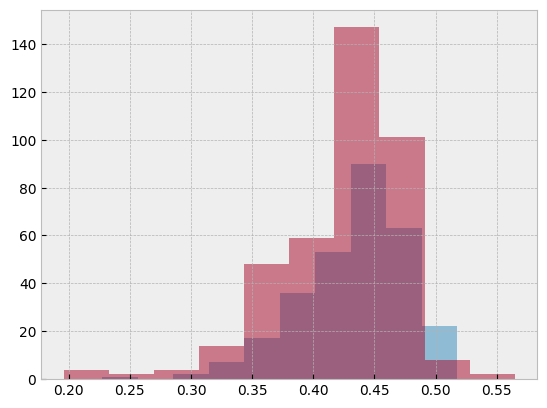

In [44]:
# We check for common support in the distributions, plotting histograms for the probabilities of
# both groups who signed up for the wine club and those who did not,
# each with an opacity of 0.5 to visually compare their overlap.
df.loc[df.wine_club_signup==1]['probabilities'].hist( alpha=0.5)
df.loc[df.wine_club_signup==0]['probabilities'].hist(alpha=0.5)

In [45]:
# KNeighborsRegressor for finding matches. Separating observations of signed up and not signed up
wine_club_signups = df.loc[(df.wine_club_signup==1)]
nowine_club_signups = df.loc[(df.wine_club_signup==0)]

modelo_no_wine_club_signups = KNeighborsRegressor(n_neighbors=1).fit(nowine_club_signups['probabilities'].values.reshape(-1, 1), nowine_club_signups.premium_wine_interest)

In [46]:
# We ask the model to find the match for non-wine_club_signup (predict the corresponding non-wine_club_signup).
# The matched data frame is then created by assigning each wine club signup a predicted match from non-signups based on their probabilities.
# Finally, the average difference in premium wine interest between the wine club signups and their matched non-signups is calculated.

df_matched=wine_club_signups.assign(matchnowine_club_signup=modelo_no_wine_club_signups.predict(wine_club_signups['probabilities'].values.reshape(-1, 1)))

df_matched

,random_id,ad_exposure_wine_club,wine_club_signup,digital_engagement_level,household_wine_spending,wine_preference_diversity,previous_wine_purchase_online,premium_wine_interest,ddigital_engagement_level,probabilities,matchnowine_club_signup
1,2,1,1,1,45.0,0.0,0.0,57.14,1,0.480581,85.40
3,4,1,1,1,54.0,1.0,1.0,85.71,1,0.429416,85.71
6,7,1,1,1,29.0,1.0,1.0,56.34,1,0.480480,52.46
7,8,0,1,1,52.0,1.0,1.0,71.43,1,0.433460,36.30
8,9,1,1,1,66.0,0.0,0.0,9.55,1,0.437613,61.72
...,...,...,...,...,...,...,...,...,...,...,...
686,687,0,1,1,45.0,0.0,0.0,71.43,1,0.480581,85.40
688,689,1,1,1,73.0,1.0,1.0,45.09,1,0.391530,26.87
690,691,1,1,2,47.0,0.0,0.0,62.46,0,0.394495,33.16
694,695,1,1,1,51.0,1.0,1.0,71.43,1,0.435486,71.43


In [47]:
np.mean(df_matched.premium_wine_interest-df_matched.matchnowine_club_signup)

-6.504467353951891

## Using the Causal Inference library


In [48]:
X=['ddigital_engagement_level', 'household_wine_spending', 'wine_preference_diversity', 'previous_wine_purchase_online']

In [49]:
cm = CausalModel( Y=df["premium_wine_interest"].values,  D=df["wine_club_signup"].values,  X=df[X].values )

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)
cm.reset()


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.610      2.825      0.924      0.356     -2.927      8.147
           ATC      3.356      3.053      1.099      0.272     -2.629      9.340
           ATT      1.613      3.041      0.530      0.596     -4.348      7.573



/usr/local/lib/python3.10/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


## Propensity Score using Causal Model
The output from running the CausalModel code includes estimated parameters of the propensity score and a stratification summary. The estimated parameters indicate the coefficients, standard errors, z-values, p-values, and confidence intervals for the intercept and variables X0 and X1, suggesting the influence of these variables on the likelihood of wine club signup. The stratification summary shows the propensity score ranges, sample sizes, average propensities, and raw differences in outcomes across strata, which helps in understanding the effect of wine club signup across different propensity score ranges.

In [50]:
causal = CausalModel(
    Y=df["premium_wine_interest"].values,
    D=df["wine_club_signup"].values,
    X=df[X].values
)
causal.est_propensity_s()
print(causal.propensity)
causal.stratify_s()
print(causal.strata)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -0.134      0.355     -0.378      0.706     -0.830      0.562
            X0      0.281      0.194      1.449      0.147     -0.099      0.661
            X1     -0.007      0.006     -1.317      0.188     -0.018      0.004


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.299     0.404       112        66     0.367     0.374     4.215
         2     0.406     0.441        92        79     0.425     0.427    -1.558
         3     0.442     0.529       185       146     0.460     0.461    -0.809



/usr/local/lib/python3.10/dist-packages/causalinference/core/summary.py:110: RuntimeWarning: invalid value encountered in divide
  return (mean_t-mean_c) / np.sqrt((sd_c**2+sd_t**2)/2)


The estimated parameters indicate that the coefficients for the intercept and variables X0 and X1 do not significantly predict the likelihood of wine club signup, as suggested by their p-values. In the stratification summary, the propensity score ranges define three strata with varying control and treated group sizes. The raw differences in outcomes (premium wine interest) show variation across strata, with the first stratum showing a positive difference and the other two showing negative differences, indicating varied effects of wine club signup on premium wine interest across different propensity score groups.

The results suggest that the impact of the wine club membership campaign on premium wine interest varies across different groups, without clear evidence of a significant overall effect. For the marketing team, this means that while the campaign may not have broadly influenced premium wine interest as hoped, there may be specific segments where the campaign was more effective. It could be worthwhile to analyze these segments more deeply to understand where the campaign resonated and consider tailoring future efforts to similar audiences or adjusting the campaign to better target or appeal to broader audiences.